# Exercise 5, October 16, 2020, Financial Engineering I, Kaila
Solutions for the Python exercises

If you don't have ```pyfinance```, ```datar```, or ```plotnine``` installed, run the following:

In [1]:
import sys
!{sys.executable} -m pip install pyfinance
!{sys.executable} -m pip install datar
#!{sys.executable} -m pip install plotnine

     |████████████████████████████████| 57 kB 5.0 MB/s eta 0:00:011
     |████████████████████████████████| 10.3 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 25.1 MB/s eta 0:00:01
     |████████████████████████████████| 28.4 MB 34.9 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 18.5 MB/s eta 0:00:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.5.3
    Uninstalling scipy-1.5.3:
      Successfully uninstalled scipy-1.5.3
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.37.0 requires slicer==0.0.3, but you have slicer 0.0.7 which is incompatible.


These are packages used in this exercise set.

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm
import pandas as pd
from pyfinance.options import BSM
from mpl_toolkits.mplot3d import Axes3D
from datar import f
from datar.dplyr import mutate, filter, if_else, pull, group_by, select

## Solution of Exercise 4, problem 5 (last week) 
Compute the Black-Scholes call using either the formula or a Python command

In [3]:
S = 100
E = 100
T = .5
sigma = .3
r = .05
eps = np.finfo(float).eps

We write the Black-Scoles formula
Note that here you are using the same ```norm.cdf``` command as when drawing cumulative normal distributions/densities. As here, we use the normal standard cumulative density, we can write either ```norm.cdf(d1)``` or ```norm.cdf(d1,0,1)```.

In [4]:
d1 = (np.log(S / E) + (r + sigma ** 2 / 2) * T) / (np.sqrt(sigma ** 2 * T) + eps)
d2 = d1 - np.sqrt(sigma ** 2 * T)
C = norm.cdf(d1) * S - E * np.exp(-r * T) * norm.cdf(d2)
print(C)
delta = norm.cdf(d1); print(delta)

9.634876628449184
0.5885891135975725


In [5]:
op = BSM(kind='call', S0=S, K=E, T=T, r=r, sigma=sigma)
Cdirectly = op.value() ; print(Cdirectly)

9.634876628449184


You can proceed in the same way with the rest of the exercise. Alternatively, you can define the Black-Scholes price in a function, and call it, in the same way than in the problem 2 in exercises 4.

## Exercise 1
A three-month at-the-money call on an underlying asset with spot price $S=30$ and which pays no dividends is worth $C_{obs}=2.5$. Assume that the risk free interest rate is $r=0.06$. Compute the implied volatility $\sigma$ with accuracy of six decimal digits by using the Newton's method. Use an initial guess of $\sigma_0 = 0.5$. You may also try the bisection method on the interval $[0.0001,1]$. Search then the Python algorithm for the implied volatility by searching ´implied_vol´ in ´pyfinance.options´ package, compute the implied volatility with this command and compare your result.

First, try to write the code yourself. Below you have the correct code. We have added machine epsilon eps = 10⁻¹⁶ in the denominator of d₁ to prevent division by 0. Python can get confused when dividing something by 0.

In [6]:
S = 30.0
E = 30.0
Cobs = 2.5
r = .06
T = 0.25

We use Newton's method to recover the implied volatility. Here the machine $\epsilon$ term ```eps``` is added to avoid division by zero.

In [7]:
def vola(S, E, r, T, Cobs):
    vola = .5
    d = 1
    while(d > eps):
        d1 = (np.log(S / E) + (r + vola ** 2 / 2) * T) / (vola * np.sqrt(T) + eps)
        d2 = d1 - vola * np.sqrt(T)
        C = S * norm.cdf(d1) - E * np.exp(-r * T) * norm.cdf(d2)
        vDer = S * np.sqrt(T) * np.exp(-d1 ** 2 / 2) / (np.sqrt(2 * np.pi) + eps)
        d = (Cobs - C) / -vDer
        vola = vola - d
    return vola

print(vola(S, E, r, T, Cobs))

op1 = BSM(kind='call', S0=S, K=E, T=T, r=r, sigma=sigma)
print(op1.implied_vol(value=Cobs))

0.38271922670102126
0.3827192267707694


You can also use a more general form for several options and strikes:

In [8]:
E    = np.array([22, 24, 26, 28, 30, 32, 34, 36, 38])
Cobs = np.array(list(map(lambda k: BSM(kind='call', S0=S, K=k, T=T, r=r, sigma=0.1).value(), E )))

where ```L``` is the amount of options with different strikes

In [9]:
def vola_m(S, E, r, T, Cobs):
    if(len(E) != len(Cobs)): return None
    L = len(E)
    vola = .5 * np.ones(L)
   
    for k in range(L):
        d = 1
        if(np.isnan(Cobs[k])): 
            vola[k] = np.nan
            d = 0
        while(d > eps):
            d1 = (np.log(S / E[k]) + (r + vola[k] ** 2 / 2) * T) / (vola[k] * np.sqrt(T) + eps)
            d2 = d1 - vola[k] * np.sqrt(T)
            C = S * norm.cdf(d1) - E[k] * np.exp(-r * T) * norm.cdf(d2)
            vDer = S * np.sqrt(T) * np.exp(-d1 ** 2 / 2) / np.sqrt(2 * np.pi) + eps
            d = (Cobs[k] - C) / -vDer
            vola[k] = vola[k] - d
            
    return vola

print(vola_m(S, E, r, T, Cobs))

[0.10000095 0.1        0.1        0.1        0.1        0.1
 0.1        0.1        0.1       ]


A simpler way would be to use the original function for implied volatility, and use mapping:

In [10]:
def vola_map(S, E, r, T, Cobs):
    return list(map(lambda e, c :vola(S,e,r,T,c), E, Cobs ))

In [11]:
print(vola_map(S, E, r, T, Cobs))

[0.1000002132338433, 0.10000000001523583, 0.10000000000004489, 0.09999999999999967, 0.10000000000000032, 0.09999999999999919, 0.10000000000000016, 0.09999999999999801, 0.1000000000000011]


We can also use the `BSM` object from `pyfinance.options` package, and the ready `implied_vol(value= )` method.

In [12]:
BSM(kind='call', S0=S, K=22.0, T=T, r=r, sigma=sigma).implied_vol(value = 8.5)

0.44022420930965694

## Exercise 2
Copy the file FEexercise5_2021Data.xls from the course homepage, 'Exercise 5'.

Try the following things:

(a) Plot the stock price as a function of time.

(b) Plot a surface of the call prices as a function of strikes and time; you can use the command `plot_surface` from the `plotly` package.

(c) Estimate the implied volatility; plot volatility smiles and a volatility surface.

In [13]:
data = pd.read_excel('FEexercise5_2021Data.xls')

In [14]:
print(data)

    Unnamed: 0       200       220       240       260       270       280  \
       <int64> <float64> <float64> <float64> <float64> <float64> <float64>   
0           86       NaN       NaN       NaN       NaN       NaN       NaN   
1           85       NaN       NaN       NaN       NaN       NaN       NaN   
2           84       NaN       NaN       NaN       NaN       NaN       NaN   
3           83       NaN       NaN       NaN       NaN       NaN       NaN   
..         ...       ...       ...       ...       ...       ...       ...   
4           82       NaN       NaN       NaN    225.25       NaN    205.25   
80           6    329.60    309.60    289.60    269.60    259.60    249.05   
81           5    325.50    305.50    285.50    265.50    255.50    245.50   
82           4    328.55    308.55    288.55    268.55    258.55    248.55   
83           3    330.10    310.10    290.10    270.10    260.10    250.10   
84           2    324.10    304.10    284.25    264.10    254.10

If the Excel file had several sheets, you would write ```a = pd.read_excel('FEexercise5_2020Data_Matlab_R.xls', sheet_name = 'xxx')```. We'll adjust the names of the columns.

In [15]:
data.rename({'Unnamed: 0':'T', 'Unnamed: 66':'S', 'Unnamed: 67':'r'}, axis='columns', inplace=True)
print(data)

         T       200       220       240       260       270       280  \
   <int64> <float64> <float64> <float64> <float64> <float64> <float64>   
0       86       NaN       NaN       NaN       NaN       NaN       NaN   
1       85       NaN       NaN       NaN       NaN       NaN       NaN   
2       84       NaN       NaN       NaN       NaN       NaN       NaN   
3       83       NaN       NaN       NaN       NaN       NaN       NaN   
..     ...       ...       ...       ...       ...       ...       ...   
4       82       NaN       NaN       NaN    225.25       NaN    205.25   
80       6    329.60    309.60    289.60    269.60    259.60    249.05   
81       5    325.50    305.50    285.50    265.50    255.50    245.50   
82       4    328.55    308.55    288.55    268.55    258.55    248.55   
83       3    330.10    310.10    290.10    270.10    260.10    250.10   
84       2    324.10    304.10    284.25    264.10    254.10    244.10   

         290       300       305  ...

We want to follow the [tidy data principle](https://tidyr.tidyverse.org/articles/tidy-data.html), where each observation (one option at a certain date) has its own row, and all the variables their own columns (strike price is a variable). We drop the cases where the options haven't opened yet. Then we still need to perform our scalings for the variables (why?).

In [16]:
data1 = data.melt(id_vars=['T', 'r', 'S'], var_name="E").dropna()

data1.rename({'value':'Cobs'}, axis='columns', inplace=True)

data1 = data1 >> mutate(r = f.r/100, T = f.T/252, S = f.S/1000, E = f.E/1000, Cobs = f.Cobs/1000)

print(data1)

             T         r         S        E      Cobs
     <float64> <float64> <float64> <object> <float64>
5     0.321429    0.0011   0.49169      0.2   0.29245
6     0.317460    0.0011   0.49025      0.2   0.29025
7     0.313492    0.0011   0.48835      0.2   0.28950
8     0.309524    0.0011   0.47671      0.2   0.27815
...        ...       ...       ...      ...       ...
9     0.305556    0.0012   0.47548      0.2   0.27645
5520  0.023810    0.0006   0.52861    0.585   0.00040
5521  0.019841    0.0006   0.52429    0.585   0.00010
5522  0.015873    0.0006   0.52793    0.585   0.00015
5523  0.011905    0.0006   0.52959    0.585   0.00005
5524  0.007937    0.0005   0.52411    0.585   0.00005

[3824 rows x 5 columns]


Here `T` refers to days until maturity, `S` refers to stock prices and `Cobs` to call prices, `E` for strikes and `r` for risk-free interest rates. First try to understand how the algorithm above and the Excel sheet `FEexercise5_2021Data.xls` match together.

Often, there are outliers, i.e, unrealistically large values in real data. For example, in the data you have, option prices should be less than 1. However, there may be some option prices that are 1000 times too large. In this exercise, you can use the following code to correct the outliers. First try to understand what this filter actually is doing.

We'll find the relevat data from the sheet, and adjust the scales appropriately.

In [17]:
data1 = data1 >> mutate(Cobs = if_else(f.Cobs > 1, f.Cobs/1000, f.Cobs))

Having chosen an initial guess A, you can compute the implied volatility vector consisting of options with different strikes and maturities with either `vola` or `implied_vol` functions from the first Problem.

Often, as with your data, some values of the implied volatility will be extremely high and plotting the surface leads to nonsense. When you have an estimate for `vola`, you should drop values below zero or over $0.6$ before saving the estimate as `impliedVol`, as this would be ridiculously high in this context (but not always!). By defining these volatilities as `NaN` we can plot beautiful pictures.
### Solution

a)  You can extract a column out from the DataFrame with the `pull()` command

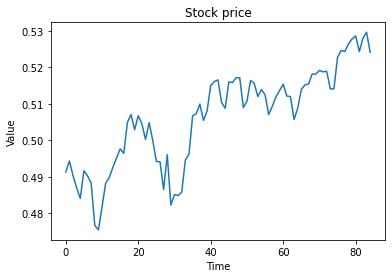

In [19]:
S  = data >> pull(f.S)
plt.plot(S/1000)
plt.title("Stock price")
plt.xlabel('Time')
plt.ylabel('Value')
plt.style.use('ggplot')
plt.show()

or you can use directly the `plotnine` package, if you want more professional graphics.

In [21]:
!{sys.executable} -m pip install plotnine
from plotnine import ggplot, aes, geom_line, theme_classic, labs, geom_line, geom_smooth

     |████████████████████████████████| 4.7 MB 7.1 MB/s eta 0:00:01     |███████████████▉                | 2.3 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 63 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 111 kB 33.4 MB/s eta 0:00:01


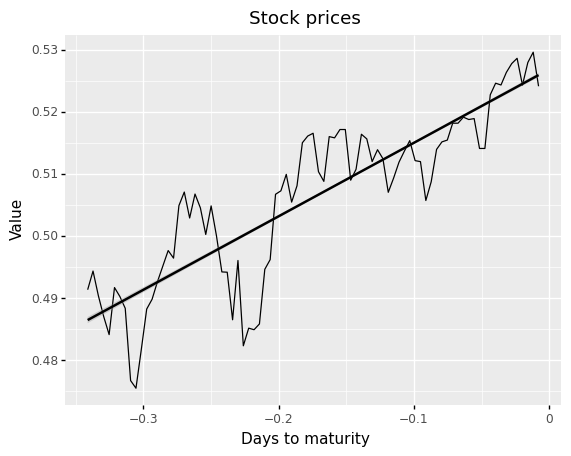

<ggplot: (8739499995076)>

In [22]:
(data1 >> mutate(T = -1 * f.T) >>
  ggplot(aes(x = 'T' , y = 'S')) +
  geom_line() + geom_smooth(method = 'lm' , se = True) +
  labs(title ="Stock prices", x = "Days to maturity", y = "Value"))

b)  Here we plot the observed option prices as a function of the time to maturity and the strike process. The nice part of using `Axes3D` is that one can rotate the graph with your changing the values `elev` and `azim`. You can see that we rescaled the variables just to make the numbers more understandable.

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

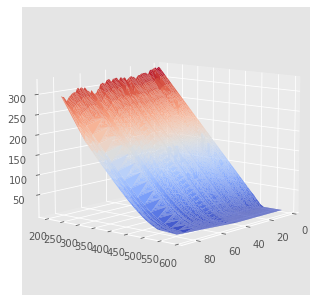

In [24]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(252*data1['T'], 1000*data1['E'], 1000*data1['Cobs'], cmap=cm.coolwarm, linewidth=0.2)
ax.view_init(elev=10, azim=40)

plt.show()

We can use the defined functions from Problem 1, we'll use the ready function from `pyfinance`, which does basically the same thing as our own function `vola`, but faster (as it is written in C++). We will add a new column to our data frame, which contains the volatilities. We should notice, that there is not always an implied (Black-Scholes) volatility for all parameter combinations, for these will set `NaN`.

In [25]:
data1['volatility'] = data1.apply(lambda row:  BSM(kind='call', S0=row['S'], K=row['E'], T= row['T'], r=row['r'], sigma=0.1).implied_vol(value = row['Cobs']), axis = 1)
print(data1)

/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:149: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:151: RuntimeWarning: overflow encountered in double_scalars
/opt/conda/lib/python3.8/site-packages/pyfinance/options.py:242: RuntimeWarning: overflow encountered in double_scalars


             T         r         S        E      Cobs  volatility
     <float64> <float64> <float64> <object> <float64>   <float64>
5     0.321429    0.0011   0.49169      0.2   0.29245    0.732913
6     0.317460    0.0011   0.49025      0.2   0.29025         NaN
7     0.313492    0.0011   0.48835      0.2   0.28950    0.788564
8     0.309524    0.0011   0.47671      0.2   0.27815    0.807695
...        ...       ...       ...      ...       ...         ...
9     0.305556    0.0012   0.47548      0.2   0.27645    0.757919
5520  0.023810    0.0006   0.52861    0.585   0.00040         NaN
5521  0.019841    0.0006   0.52429    0.585   0.00010         NaN
5522  0.015873    0.0006   0.52793    0.585   0.00015         NaN
5523  0.011905    0.0006   0.52959    0.585   0.00005         NaN
5524  0.007937    0.0005   0.52411    0.585   0.00005         NaN

[3824 rows x 6 columns]


Finally, we filter away the unwanted values, i.e. volatility smaller than zero and larger than $0.6$.

In [31]:
data2 = data1 >> filter(f.volatility > 0.6)

Plotting these we can take several approaches. We can use `ggplot`,

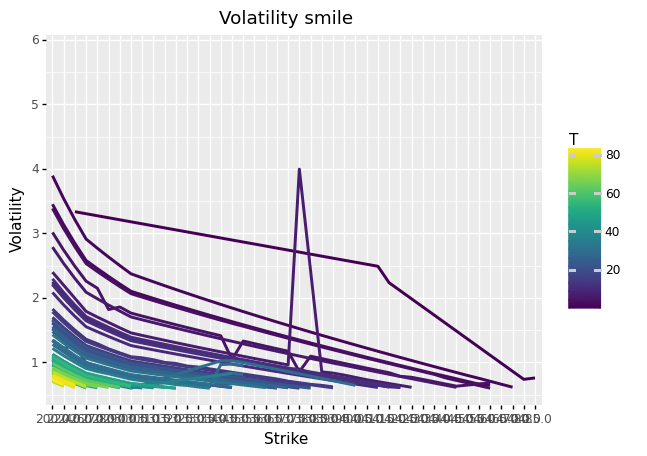

<ggplot: (8739498476963)>

In [56]:
(data2 >>  mutate(E = 1000 * f.E, T = 252 * f.T) >> ggplot(aes(x='E', y='volatility', group = 'T'))+ geom_line(aes(color='T'), size=1.2) +
        labs(title ="Volatility smile", x = "Strike", y = "Volatility") )

This is quite messy and we concentrate on just a part of the graph,

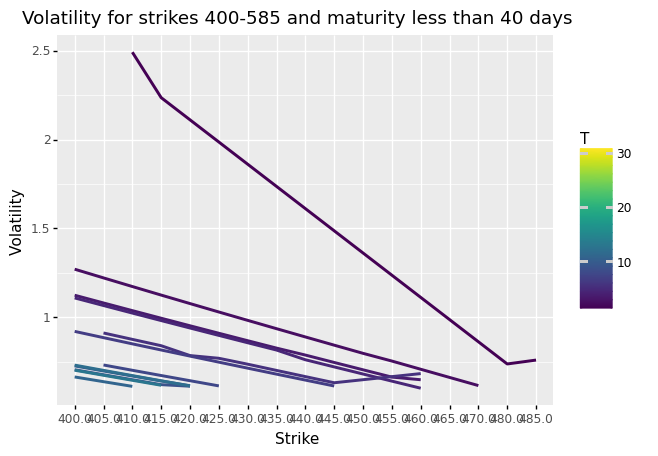

<ggplot: (8739499176954)>

In [55]:
(data2 >> filter(f.E>=0.4, f.T< 40/252) >>  mutate(E = 1000 * f.E, T = 252 * f.T) >> ggplot(aes(x='E', y='volatility', group = 'T'))+geom_line(aes(color='T'), size=1.2) +
            labs(title ="Volatility for strikes 400-585 and maturity less than 40 days", x = "Strike", y = "Volatility ") )

Plotting the volatility surface we get

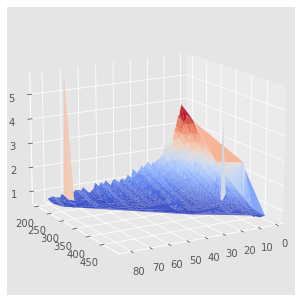

In [32]:
fig1 = plt.figure()
ax1 = Axes3D(fig1)
ax1.plot_trisurf(252*data2.dropna()['T'], 1000*data2.dropna()['E'], data2.dropna()['volatility'], cmap=cm.coolwarm, linewidth=0.2)
ax1.view_init(elev=15, azim=60)

plt.show()

## Problem 3

Barrier options: Explain why a regular European call option is the sum of a down-and-out European call and a down-and-in European call. If the price of a down-and-out call plus the corresponding down-and-in call is not equal to the price of the corresponding vanilla call, construct an arbitrage portfolio.

### Solution

If the barrier is reached the down-and-out option is worth nothing while the down-and-in option has the same value as a regular option. If the barrier is not reached the down-and-in option is worth nothing while the down-and-out option has the same value as a regular option. This is why a down-and-out call option plus a down-and-in call option is worth the same as a regular option.

## Exercise 4

*Barrier options*: Compute the prices of

-   a regular European call option $C_t(S_t, E)$ on a non-dividend-paying stock, where $S_t=50$, $E=50$, $r=0.05$, $T=1$ (in years) and $\sigma=0.3$;

-   a down-and-out European call which is a regular European call with the barrier $B=45$;

-   a down-and-in European call which is a regular European call with the barrier $B=45$.

The closed form price of a down-and-out call, $V_t(S_t,E)$, with $B<E$ is given by$$V_t(S_t,E)=C_t(S_t,E)-\left(\frac{S_t}{B}\right)^{1-2r/\sigma^2}C_t(B^2/S_t,E).$$

Compute the price of each options. You can use the command `EuropeanOption` from `RQuantLib` package (or you can try out the `BarrierOption` in the same package) to compute the Black-Scholes prices. In which situation would you choose a down-and-out or down-and-in call instead of a regular call?

### Solution

In [75]:
S = 50
E = 50
r = .05
T = 1
sigma = .3
B = 45

vanillaCall = BSM(kind='call', S0=S, K=E, T=T, r=r, sigma=sigma).value()

auxCall = BSM(kind='call', S0=B ** 2 / S, K=E, T=T, r=r, sigma=sigma).value()

downAndOut = vanillaCall - (S / B) ** (1 - (2 * r / (sigma ** 2))) * auxCall

downAndIn = vanillaCall - downAndOut

print('Regular call %f, Down-and-out call %f, Down-and-in call %f.'%(vanillaCall, downAndOut, downAndIn))

Regular call 7.115627, Down-and-out call 4.696388, Down-and-in call 2.419240.


## Problem 5

Price a down-and-out call and down-and-in call consistently with the European call Excel data set. In the formula above, you should then use as $\sigma$ the implied volatility from liquid European calls computed from the data set. You may choose a maturity of one month and try different strike prices E and barriers B, so long as B \< E. There are option prices and index prices for 85 different maturities. For example, if you choose a 30-day maturity, you write 'mat(30)'. This tells you, how many days there are to the maturity. As we use years and not days when computing option prices with the Black-Scholes, you should divide the days with 252 (the number of trading years days in one year). Similarly, choose one strike price and the corresponding implied volatility. The index price at the maturity you have chosen is obtained with 'S(30)', for example, and the interest rate with 'r(30)'. Use these values to compute the prices of barrier options with the formula given above. What happens if you price the barrier options with a volatility that is different from the implied volatility? How can you profit from the arbitrage?

### Solution

Choose one option from the Excel sheet. Compute the implied volatility as done in Problem 2. Then, use Problem 4.

## Problem 6

*Asian options.* In this exercise, we price two kinds of Asian options based on the simulated paths of the underlying stock $S_t$. The payoff $h_{A1}$ of an Asian call option on a stock $S_0$ with maturity $T$ and strike $E$ is given by$$h_{A1}(S_T,T)=\max(\bar S_T-E,0),$$

where $\bar S_T =\frac{1}{T}\int_0^TS_sds$ is the time average of the stock price over the time interval [0, T]. There is another type of Asian option, with payoff$$h_{A2}(S_T,T)=\max (S_T-\bar S_T,0).$$

We propagate N times a stock price path from time $t=t_1$ to $T$, using$$S_T=S_0+\int_0^T\mu S_tdt +\int_0^T\sigma S_tdX_t.$$

You have already computed the stock price distribution $S_T$ at maturity in Exercise 4. This time, we need information on the whole path of the stock price, not only on the distribution at the maturity. Then, you must use two loops, one for the time steps and another for the N samples of the stock path. Alternatively, the stock price at each moment of time can be written in matrix form:

In [76]:
S0 = 50 # initial stock price
E = 50 # strike price
sig = 0.1 # expected vol.
r = 0.03 # risk free interest rate
dt = 1 / 252 # size of time step (one day)
mat = 50 # days to expiry
T = dt * mat # years to expiry

N = 1000 # Number of simulated paths
S = np.zeros([N, mat])

S[:, 0] = S0
Smean   = np.zeros(N)

Propagate N stock paths and plot them. Then, you can use these paths to price Asian options using the payoffs $h_{A1}$ and $h_{A2}$ (with the first one, take it at the money).

### Solution

We can compute the time-average of every path and plot these.

In [82]:
for i in range(N):
    for time in range(1,mat):
        S[i, time ] = S[i , time - 1 ] * (1 + r * dt + sig * np.random.normal(0,1) * np.sqrt(dt))
    
    S[i, :] = np.flip(S[i,:])
    Smean[i] = np.mean(S[i, :]) # compute the time-average of every path

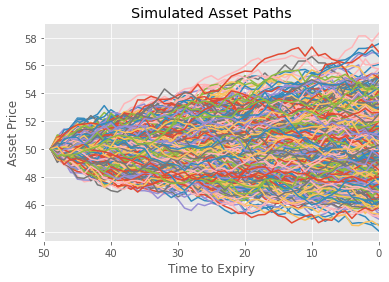

In [83]:
#figure(6)

fig, ax = plt.subplots()
ax.plot(np.transpose(S))
ax.set_xlim(mat, 0)
ax.set_xlabel('Time to Expiry')
ax.set_ylabel('Asset Price')
ax.set_title('Simulated Asset Paths')
ax.grid(True)

plt.show()

We can also use a vector form (here, I denote S=S2)

In [85]:
S2 = np.ones([N, mat])
S2[:, 0] = S0

for time in range(1, mat):
    S2[:, time ] = S2[:, time - 1].dot(1 + r * dt + sig * np.random.normal(0, 1, N) * np.sqrt(dt))


S2mean = np.mean(S2, axis = 1) # compute the time-average of every path

Calculate the payoff for each path for a put. As ```np.maximum``` compares two array of similar length, we have to use the vector ```np.zeros(N)``` to compare to the difference.

In [86]:
PutPayoffA1 = np.maximum(E - Smean, np.zeros(N) )

Calculate the payoff for each path for a call

In [87]:
CallPayoffA1 = np.maximum(Smean -  E, np.zeros(N))

Discount the expectation of all payoffs:

In [88]:
putPriceAsian1 = np.mean(PutPayoffA1) * np.exp(-r * T)
callPriceAsia1n = np.mean(CallPayoffA1) * np.exp(-r * T)

print('The price of an Asian put option %f, and the price of the call one %f.'%(putPriceAsian1, callPriceAsia1n))

The price of an Asian put option 0.432632, and the price of the call one 0.573671.


Compute prices for the second type of Asian options, calculate the payoff for each path,

In [89]:
CallPayoffA2 = np.maximum(S[:, mat - 1] - Smean, np.zeros(N))
PutPayoffA2  = np.maximum(Smean - S[:, mat - 1], np.zeros(N))

Discount the expectation of all payoffs:

In [90]:
putPriceAsian1 = np.mean(PutPayoffA1) * np.exp(-r * T)
callPriceAsia1 = np.mean(CallPayoffA1) * np.exp(-r * T)
putPriceAsian2 = np.mean(PutPayoffA2) * np.exp(-r * T)
callPriceAsia2 = np.mean(CallPayoffA2) * np.exp(-r * T)
print('The price of the first type of an Asian put option %f, and the price of the call one %f, and the put of the second kind %f, ant the call %f.'%(putPriceAsian1, callPriceAsia1n, putPriceAsian2, callPriceAsia2))

The price of the first type of an Asian put option 0.432632, and the price of the call one 0.573671, and the put of the second kind 0.573671, ant the call 0.432632.
